<a href="https://colab.research.google.com/github/hectormelo/Machine-Learning-Techniques/blob/main/Lab_2/Laboratorio2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://drive.google.com/u/0/uc?id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d&export=download)

Práctica No. 2
==============

*Clasificación de imágenes satelitales con SVM y métodos ensembles*
--------------------------------------------------------------------

Objetivos
---------

-   Familiarizarse con el algoritmo de SVM.
-   Resolver un problema de clasificación de imágenes satelitales y evaluar métricas de desempeño.
-   Familiarizarse con técnicas de Ensemble y entender cómo su aplicación puede ayudar a mejorar las métricas de desempeño en la clasificación de imágenes satelitales.

Problema
--------

-   En esta ocasión, trabajaremos con el dataset "EuroSat Dataset". Este conjunto de datos se utiliza para clasificar el uso de la tierra en imágenes geoespaciales.

Este conjunto de datos contiene imágenes que pertenecen al conjunto de datos: [EuroSat Dataset](https://www.kaggle.com/datasets/apollo2506/eurosat-dataset).

**EuroSAT** → Contiene imágenes RGB recopiladas del conjunto de datos Sentinel.

Cada imagen tiene 64x64 píxeles con una distancia de muestreo en el suelo de 10 mt y se encuentran en formato jpg

Para este laboratorio trabajatemos con el fin de facilitar el procesamiento utilizaremos un subconjunto de los datos de la carpeta EuroSAT que se encuentra en el repositorio de Github [EuroSat](https://github.com/hectormelo/Machine-Learning-Techniques/tree/main/Lab_2) y del cual utilizaremos las siguientes carpetas de clases diferentes de imágenes:

1. Forest
2. Industrial
3. PermanentCrop
4. Residential
5. River




### 0. Importación de Librerías

Para este ejercicio, utilizaremos las siguientes librerías.

In [ ]:
import os
import time

import numpy as np

import matplotlib.pyplot as plt

import cv2
import requests

from sklearn.metrics import accuracy_score # Cálculo de la precisión
from sklearn.decomposition import PCA # Análisis de componentes principales
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Matriz de confusión
from sklearn.model_selection import train_test_split # División de datos en entrenamiento y prueba
from sklearn.model_selection import GridSearchCV # Búsqueda de hiperparámetros

from sklearn.preprocessing import StandardScaler # Estandarización de datos

from sklearn.metrics import classification_report, accuracy_score # Reporte de clasificación y precisión
from sklearn.svm import SVC # Máquina de soporte vectorial

from PIL import Image #Librería para brir, manipular y guardar muchos formatos diferentes de archivos de imágenes.

from skimage import io
from zipfile import ZipFile
from io import BytesIO


#### 1. Carga y exploración de los datos

Para éste caso las imágenes se obtuvieron los datos están disponibles en
https://github.com/hectormelo/Machine-Learning-Techniques/blob/main/Lab_2/EuroSAT.zip
Kaggle: https://www.kaggle.com/datasets/apollo2506/eurosat-dataset, y en esta ocación vamos a utilizar su API para descargar los datos.

Para esto se requiere tener una cuenta de Kaggle y descargar el archivo kaggle.json asociado a la cuenta (para obtener el archivo mencionado una vez estas logeado en Kaggle, desde el perfil ir a la opción de settings y en la sección API y se da click en la opción Create New Token. Una vez tengas dicho archivo lo puede adjuntar al ambiente de trabajo o podrías descomentar las siguentes líneas de código para que te pida subir el archivo.

In [ ]:
# URL del archivo ZIP en el repositorio de GitHub
url = 'https://github.com/hectormelo/Machine-Learning-Techniques/raw/main/Lab_2/EuroSAT3.zip'

# Descargar el archivo ZIP
response = requests.get(url)
zip_content = response.content
# Descomprimir el contenido en memoria
with ZipFile(BytesIO(zip_content)) as zip_file:
    zip_file.extractall("/content/data/EuroSAT")  # Especifica el directorio donde quieres descomprimir
print("Archivo descomprimido.")

Archivo descomprimido.


Para reducir el tiempo de procesamiento, reduciremos el tamaño de las imágenes de 64X64 a 32X32.

In [ ]:
def load_image(folder,width, height):
    img, y = [], []

    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        for i in os.listdir(path):
            # Read image using OpenCV
            image = cv2.imread(os.path.join(path, i), cv2.IMREAD_COLOR)
            # Pass image from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Resize image while preserving the number of channels
            image = cv2.resize(image, (width, height))
            img.append(image)
            y.append(file)

    return np.array(img), np.array(y)

In [ ]:
#cargamos las imágenes que se encuentran en EuroSAT
X, y = load_image('/content/data/EuroSAT', 32, 32)
#Partimos el conjunto de datos en un conjunto de entrenamiento (80%) y otro de test (20%)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Tamaño de los datos
X.shape

(3750, 32, 32, 3)

In [ ]:
# Tamaño de los datos de entrenamiento
x_train.shape

(3000, 32, 32, 3)

In [ ]:
# Tamaño de los datos de prueba
x_test.shape

(750, 32, 32, 3)

En total encontramos 3.750 imágenes, de 32x32 en formato RGB, es decir maneja 3 canales (rojo, verde y azul)
El conjunto de entrenamiento queda con 3.000 imágenes y el de test con 750


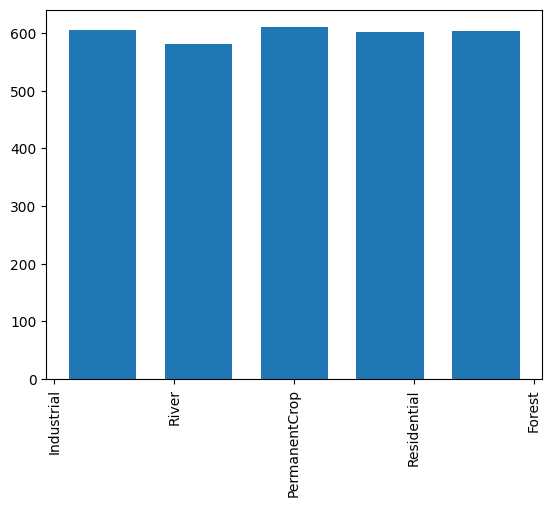

In [ ]:
# Observar distribucón de clases
plt.hist(y_train, bins=5, rwidth=0.7)
plt.xticks(rotation='vertical')
plt.show()

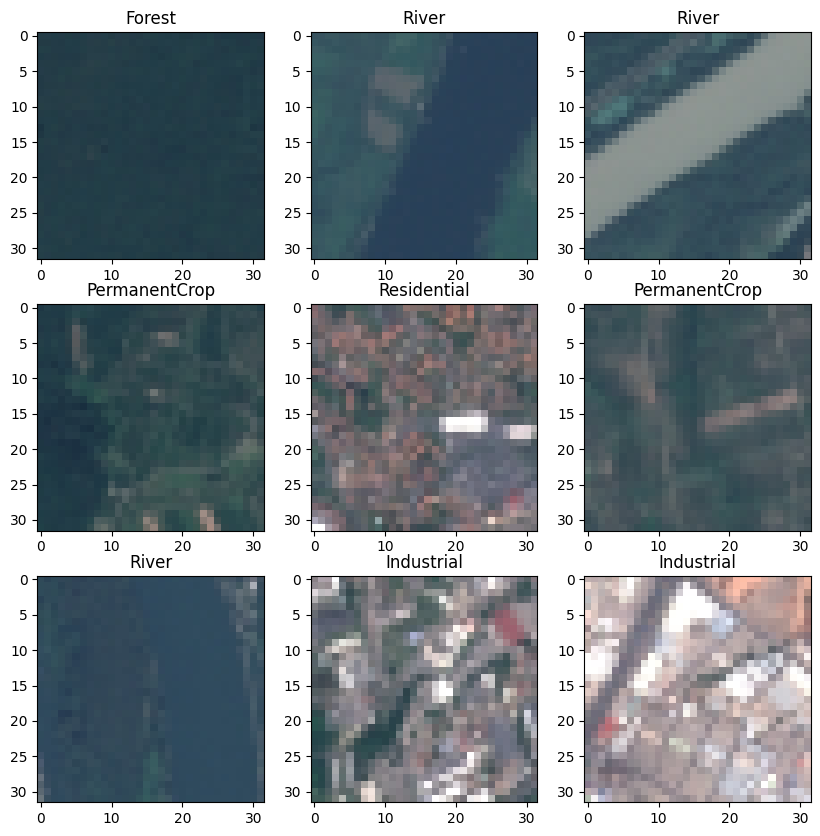

In [ ]:
# Observar las imágenes
plt.figure(figsize=(10,10))
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    rdn = np.random.randint(0, len(x_train))
    plt.imshow(x_train[rdn])
    plt.title(y_train[rdn])

In [ ]:
# Observar la distribución de los labels
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
# Para imprimir cada par clave-valor en una línea nueva de los valores de entrenaimento
print("Distribución de los labels de entrenamiento: ")
dic_entrenamiento=  dict(zip(unique_train, counts_train))
for clave, valor in dic_entrenamiento.items():
    print(f'{clave}: {valor}')
# Para imprimir cada par clave-valor en una línea nueva de los valores de test
print("\nDistribución de los labels de test: ")
dic_test= dict(zip(unique_test, counts_test))
for clave, valor in dic_test.items():
    print(f'{clave}: {valor}')

Distribución de los labels de entrenamiento: 
Forest: 603
Industrial: 605
PermanentCrop: 610
Residential: 601
River: 581

Distribución de los labels de test: 
Forest: 147
Industrial: 145
PermanentCrop: 140
Residential: 149
River: 169


#### 2. Preparación de los Datos

##### 2.1 Estandarizacion

Sabiendo que estamos trabajando con imágenes RGB podríamos hacer estandarización diviendo por 255 (el máximo valor que puede tomar un píxel en una imagen de 8 bits).

Sin embargo, en este caso haremos una aproximación con StandardScaler pues centra los datos en 0 y asegura varianza unitaria. Lo que en algoritmos sensibles a escala como SVM puede ser muy útil.

In [ ]:
# Convertir imágenes a vectores 1D
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)

# Estandarizar las imágenes
scaler = StandardScaler().fit(x_train_reshaped)
x_train_standard = scaler.transform(x_train_reshaped)
x_test_standard = scaler.transform(x_test_reshaped)

##### 2.1 PCA (Principal Component Analysis)

PCA puede ayudarnos a reducir el tiempo de entrenamiento y también puede mejorar el rendimiento del modelo al eliminar características redundantes o poco informativas

In [ ]:
# Dimensionalidad de los datos sin PCA
x_train_standard.shape

(3000, 3072)

In [ ]:
# Conservar el 95% de la varianza
pca = PCA(0.95).fit(x_train_standard)

In [ ]:
x_train_pca = pca.transform(x_train_standard)
x_test_pca = pca.transform(x_test_standard)

In [ ]:
# Numero de componentes principales
print(f"El número de componente principales que conservan el 95% de la varianza es: {pca.n_components_}")

# Dimensionalidad de los datos con PCA
x_train_pca.shape

El número de componente principales que conservan el 95% de la varianza es: 236


(3000, 236)

#### 3. Modelamiento

En esta sección, emplearemos el algoritmo Support Vector Machine (SVM) para nuestro problema de clasificación de imágenes. SVM es un algoritmo de aprendizaje supervisado que busca encontrar un hiperplano en un espacio N-dimensional (N es el número de características) que clasifique de manera óptima los inputs en categorías.


##### Support Vector Machine

<img src="https://www.researchgate.net/publication/343397484/figure/fig1/AS:920431192182789@1596459305324/An-illustration-of-support-vector-machine-SVM-intuition.jpg" width="800">

##### Consideración

Al igual que KNN, SVM no puede procesar imágenes directamente. Para utilizar imágenes en SVM, es necesario transformarlas en vectores de características. Esta transformación se realiza al convertir las imágenes en arreglos unidimensionales.

In [ ]:
# Entrenamiento y creación del modelo
start = time.time()

# Vamos a entrenarlos con varios Parámetros de C
# (Queremos un equilibrio entre la capacidad de generalización y la precisión en el conjunto de entrenamiento)
C = [0.1, 1, 10]

# Grid search
grid_search = GridSearchCV(SVC(kernel='linear', random_state=42), param_grid={'C': C}, cv=3, n_jobs=-1)

# Entrenamiento
grid_search.fit(x_train_pca, y_train)

# Tiempo de entrenamiento
end = time.time()

print(f"Tiempo de entrenamiento: {end - start}")

# Mejor modelo
best_model = grid_search.best_estimator_

Tiempo de entrenamiento: 49.280035734176636


In [ ]:
# Mejores parámetros
best_params = grid_search.best_params_
print(f"Mejores parámetros: {best_params}")

Mejores parámetros: {'C': 0.1}


In [ ]:
# Predicciones
y_pred = best_model.predict(x_test_pca)

# Evaluar el modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7133333333333334
               precision    recall  f1-score   support

       Forest       0.81      0.97      0.88       147
   Industrial       0.77      0.73      0.75       145
PermanentCrop       0.68      0.70      0.69       140
  Residential       0.57      0.64      0.60       149
        River       0.75      0.56      0.64       169

     accuracy                           0.71       750
    macro avg       0.72      0.72      0.71       750
 weighted avg       0.72      0.71      0.71       750



Matriz de confusión datos de entrenamiento
Precisión: 0.905


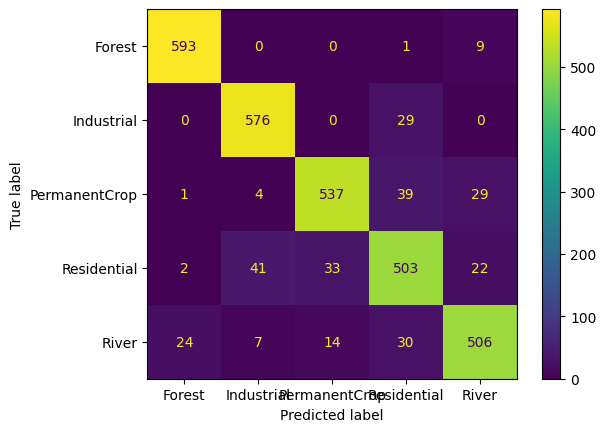

In [ ]:
# Observemos la matriz se confusión
print("Matriz de confusión datos de entrenamiento")

print("Precisión:", accuracy_score(y_train, best_model.predict(x_train_pca)))

# Matriz de confusión para entrenamiento
cm = confusion_matrix(y_train, best_model.predict(x_train_pca))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()

Matriz de confusión datos de test
Precisión: 0.7133333333333334


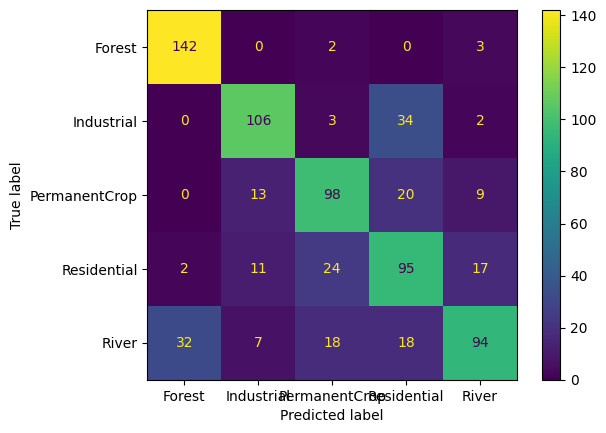

In [ ]:
# Matriz de confusión para test
print("Matriz de confusión datos de test")

print("Precisión:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()

Observemos ejemplos mal clasificados

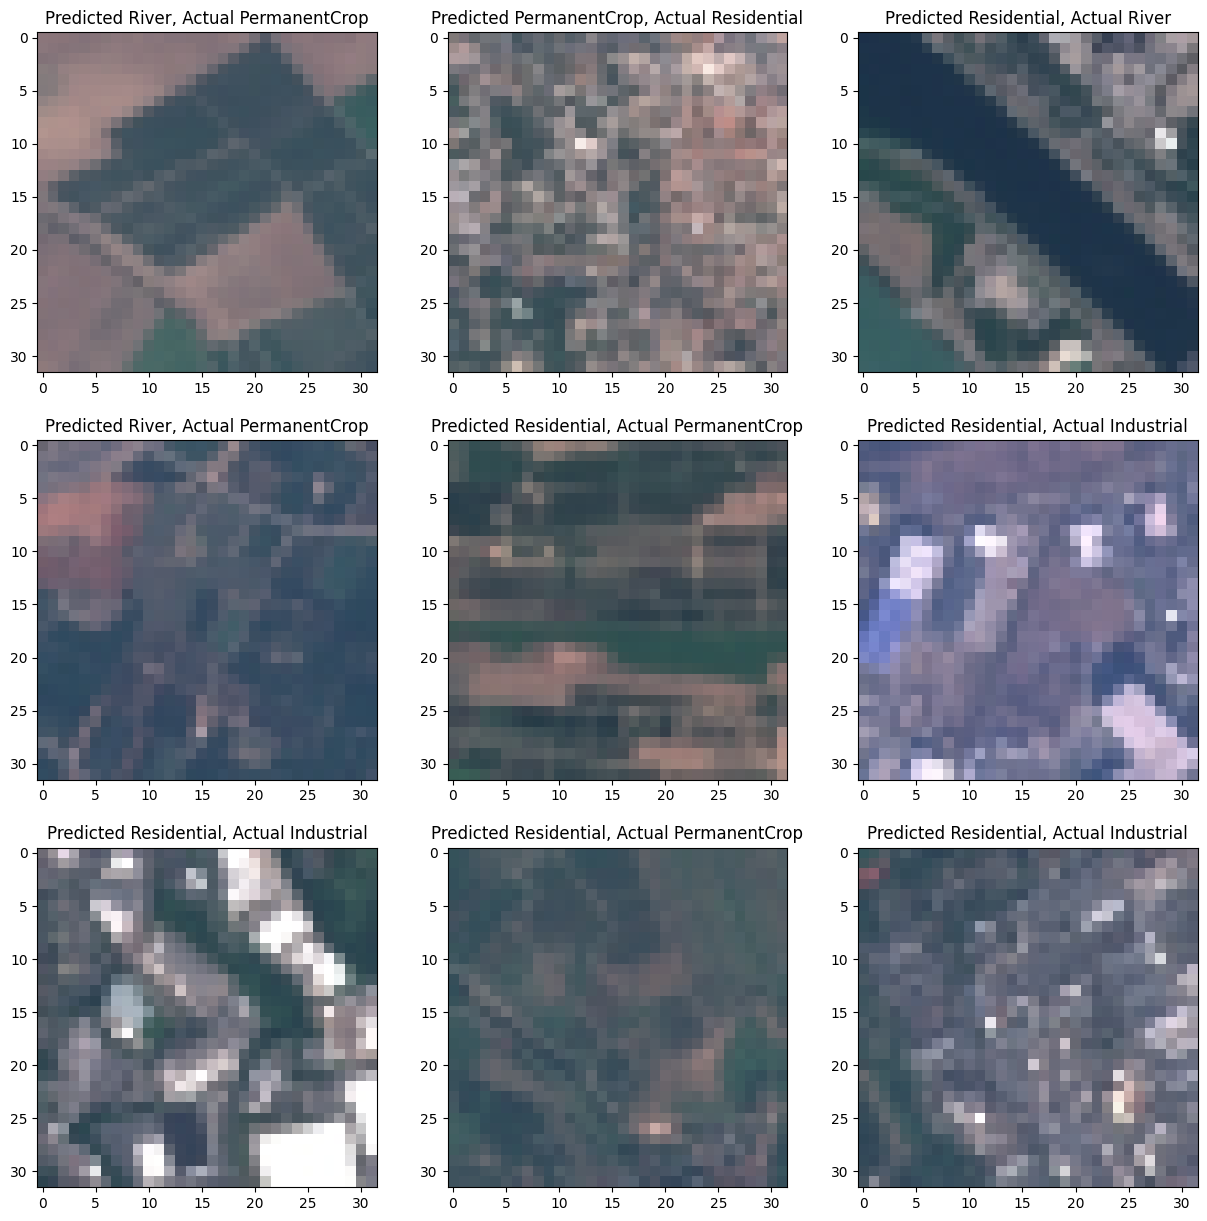

In [ ]:
# Gráfico de ejemplos mal clasificados
incorrect_indices = np.nonzero(y_pred != y_test)[0]

rdn_numbers = np.random.choice(incorrect_indices, size=min(len(incorrect_indices), 9), replace=False)

plt.figure(figsize=(15,15))
for i in range(0, min(len(incorrect_indices), 9)):
    incorrect = rdn_numbers[i]
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[incorrect], cmap='gray')
    plt.title(f"Predicted {y_pred[incorrect]}, Actual {y_test[incorrect]}")
plt.show()

- ¿A qué se debe que el modelo no clasifique correctamente estas imágenes?
- ¿Influye el valor del color de los píxeles en la clasificación?
- ¿PCA con una explicación mayor de la variancia puede ayudar a mejorar el desempeño del modelo?
- ¿Qué pasaría si se utiliza un kernel no lineal, como RBF? ¿Cómo se ajustarían los hiperparámetros?

#### 4. Metodos Ensembles

Los métodos de conjunto (Ensemble) son técnicas que combinan las predicciones de múltiples modelos con el objetivo de mejorar la robustez y precisión sobre un único modelo. Existen varios métodos Ensemble populares. En particular nos centraremos en Gradient Boosting y como podría ayudarnos a mejorar el desempeño de nuestro modelo.

##### 4.1 Gradient Boosting
Gradient Boosting es un algoritmo de optimización que se utiliza para minimizar el error al añadir modelos de manera secuencial. A diferencia de otros métodos de conjunto que entrenan modelos independientemente, Gradient Boosting entrena modelos en función del error de los modelos anteriores.

Cómo funciona:

1.  Se inicia con un modelo base.
2.  Se calcula el residuo o error entre las predicciones del modelo y los valores reales.
3.  Se entrena un nuevo modelo para predecir estos residuos o errores.
4.  Se añade este nuevo modelo al conjunto.
5.  Se repiten los pasos 2 a 4 hasta alcanzar un número determinado de modelos o hasta que el error ya no disminuya significativamente.

<img src="https://1394217531-files.gitbook.io/~/files/v0/b/gitbook-legacy-files/o/assets%2F-LvBP1svpACTB1R1x_U4%2F-Lw6zezdliKWkGknCJ6R%2F-Lw70EB_T-Y3OCO-L_4o%2Fimage.png?alt=media&token=a3edaf4a-d3d2-4c84-9a10-3d870c21d641">


Ventajas:

-   Es especialmente útil para datasets con muchas características como es el caso de las imágenes satelitales.
-   Proporciona una importante reducción del overfitting en comparación con otros métodos.

##### 4.2 Aplicación en nuestro problema

Con un ajuste adecuado de hiperparámetros y una cuidadosa validación, podemos esperar que Gradient Boosting potencie significativamente la precisión de nuestro clasificador. En particular, utilizando Scikit-Learn podemos definir y entrenar un modelo de Gradient Boosting por medio de la clase GradientBoostingClassifier. Cabe resaltar que que Gradient Boosting puede trabajar con una mayor cantidad de características que otros modelos, por lo que podríamos considerar trabajar con una representación de PCA que conserve un porcentaje más alto de la varianza.